In [1]:
import asyncio
import logging
import math
import time
import typing as tp
from functools import singledispatch
from datetime import datetime

import apds9930
# import numpy as np
# from pyowm.owm import OWM
from PIL import Image, ImageDraw, ImageFont
import apds9930
from rgbmatrix import RGBMatrix, RGBMatrixOptions


apds9930.APDS9930_IDs = [0x29, 0x39]

In [2]:
class Tablo:
    def __init__(self, brightness: int = 30) -> None:
        options = RGBMatrixOptions()
        options.drop_privileges = False
        options.rows = 64
        options.cols = 128
        options.chain_length = 1
        options.led_rgb_sequence = 'RBG'
        options.panel_type = 'FM6126A'
        options.hardware_mapping = 'regular'
        options.gpio_slowdown = 4
        options.pwm_bits = 8
        options.pwm_dither_bits = 2
        options.pwm_lsb_nanoseconds = 1000

        self.image = Image.new('RGB', (128,64), 'black')

        self.matrix = None
        self.options = options
        self.start_matrix(options, brightness)
    
    def start_matrix(self, options = None, brightness = 30):
        if options is None: options = self.options
        if self.matrix is not None:
            del self.matrix
#             time.sleep(.5)
        self.matrix = RGBMatrix(options = options)
        self.matrix.brightness = brightness
        self.update()


    def update(self, brightness: tp.Optional[int] = None) -> None:
        if brightness is not None:
            self.matrix.brightness = brightness
        self.matrix.SetImage(self.image)

    def clear(self) -> None:
        self.image = Image.new('RGB', (128,64), 'black')
        self.update()
        

Widget = tp.TypeVar('Widget')

class Widget:
    running_set: tp.Set[Widget] = set()

    @staticmethod
    def stop_all():
        for w in Widget.running_set.copy():
            w.stop()

    def __init__(self, size: tp.Tuple[int, int], position = (0,0)) -> None:
        self.w, self.h = self.size = size
        self.x, self.y = self.position = position
        self.task: tp.Optional[asyncio.Task] = None
        
        self.image = Image.new("RGB", self.size, '#000000')
        self.draw = ImageDraw.Draw(self.image)

    def clear(self) -> None:
        self.draw.rectangle((0,0)+self.size, fill='#000000')
        #self.place()

    def _place(self) -> None:
        tablo.image.paste(self.image, box=self.position)
        tablo.update()

    def update_frame(self):
        pass
        #to be defined in subclasses individually

    async def _start(self, rr: float) -> None:
        Widget.running_set.add(self)
        while self in Widget.running_set:
            self.update_frame()
            self._place()
            await asyncio.sleep(rr - time.time() % rr)

    def start(self, rr: float=5) -> Widget:
        if self in Widget.running_set:
            raise Warning("Trying to start smth already running. Nothing is done.")
            return
        self.task = asyncio.create_task(self._start(rr),
                                        name=str(self.__class__.__name__)
                                        )
        return self

    def stop(self) -> None:
        Widget.running_set -= {self}
        # asyncio.wait_for(asyncio.wait(self.task), timeout=1)

In [3]:

try:
    del(tablo)
    Widget.stop_all()
    time.sleep(1)
except Exception:
    pass
tablo = Tablo(100)

In [4]:
[t.cancel() for t in asyncio.all_tasks()]

[]

In [10]:
Widget.stop_all()
tablo.clear()

In [27]:
class Test_W(Widget):
    colors = ["yellow" ,"red", "green", "blue", "white"]

    def __init__(self, *args):
        super().__init__(*args)
        self.n = 0

    def update_frame(self):
        y = self.n % self.h
        color = self.colors[self.n//self.h]
        self.draw.line((0, y,self.w, y), fill=color)
        self.n += 1
        self.n %= self.h*len(self.colors)

async def run_test():
    example = Test_W((128, 64),(0,0))
    example.start(rr=0.02)
    await asyncio.sleep(3600*10)
    example.stop()
    tablo.clear()
    
asyncio.create_task(run_test())
asyncio.all_tasks()

{<Task pending name='Task-1' coro=<run_test() running at <ipython-input-6-0821fe03b7ea>:18> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf45a1358>()]>>,
 <Task pending name='Task-17' coro=<run_test() running at <ipython-input-27-22154341c9cf>:15>>,
 <Task pending name='Task-3' coro=<run_test() running at <ipython-input-7-22154341c9cf>:18> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf45a1ef8>()]>>}

In [28]:
tablo.update(10)

In [29]:
DEFAULT_FONT = '/home/pi/Hack-Regular.ttf'

class Time_W(Widget):
    def __init__(self, *args,
                 timezone: int=+3, t_format: str="%p %I:%M:%S",
                 font_name: str=DEFAULT_FONT, font_color="#ffffff"
                 ) -> None:
        super().__init__(*args)
        self.timezone = timezone
        self.t_format = t_format
        self.font_obj = ImageFont.truetype(font_name, self.h)
        self.font_color = font_color
    def update_frame(self) -> None:
        self.clear()
        t = time.time() + 3600*self.timezone
        t = time.gmtime(t)
        t_str = time.strftime(self.t_format, t)
        self.draw.multiline_text((0,0), t_str, fill=self.font_color, font=self.font_obj)

In [30]:
class Time_Arrows_W(Widget):
    def __init__(self, *args, timezone: int=+3) -> None:
        super().__init__(*args)
        self.timezone = timezone

    def update_frame(self) -> None:
        self.clear()
        t = time.time()
        r = min(self.w, self.h)/2
        for i in range(12):
            x1 = r + r*math.cos(math.pi*i/6)
            y1 = r + r*math.sin(math.pi*i/6)
            x2 = r + 0.93*r*math.cos(math.pi*i/6)
            y2 = r + 0.93*r*math.sin(math.pi*i/6)
            fill="#ffffff" if i%3==0 else "#990000"
            self.draw.line((x1,y1,x2,y2), fill=fill)
        
        hx =   0.6*r*math.sin(math.pi*( (t/3600)%24+self.timezone )/6)
        hy = - 0.6*r*math.cos(math.pi*( (t/3600)%24+self.timezone )/6)
        self.draw.line((r,r,r+hx,r+hy), fill="#ffffff")
        
        mx =   0.9*r*math.sin(math.pi*( (t/60)%60 )/30)
        my = - 0.9*r*math.cos(math.pi*( (t/60)%60 )/30)
        self.draw.line((r,r,r+mx,r+my), fill="#ffffff")
        
        sx =   r*math.sin(math.pi*(t%60)/30)
        sy = - r*math.cos(math.pi*(t%60)/30)
        self.draw.line((r+sx,r+sy,r+0.95*sx,r+0.95*sy), fill="#ffffff")

In [31]:
class BrightnessScheduler():
    def _init_sensor(self):
        self.sensor = apds9930.APDS9930(1)
        self.sensor.set_mode(apds9930.ALL, True)

    def __init__(self):
        self.task = None
        # self.history = np.zeros((20,))
        self.current_brightness = None
        self._running = False
        self._init_sensor()

    def count_brightness(self, light):
        if light < 0:
            light = 1500
        brightness = 1.25*light**.65
        brightness = round(brightness)
        brightness = min(100, brightness)
        brightness = max(3, brightness)
        return brightness

    async def _start(self, rr = .1):       
        while self._running:
            try:
                new_brightness = self.count_brightness(self.sensor.ambient_light)
                if self.current_brightness != new_brightness:
                    self.current_brightness = new_brightness
                    tablo.update(new_brightness)
            except:
                try: self._init_sensor()
                except: pass
            await asyncio.sleep(rr)
    def start(self, *args, **kwargs):
        self._running = True
        self.task = asyncio.create_task(self._start(*args, **kwargs))
        return self
    def stop(self):
        self._running = False
        
try:
    bs.stop()
except Exception:
    pass

# bs = BrightnessScheduler()
# bs.start(rr=.05)

In [32]:
class AmbientSensor_W(Widget):
    def __init__(self, size, position=(0,0), sensor=None,
                 font_name=DEFAULT_FONT, font_color='#808080', err_color="#F03030"):
        
        super().__init__(size=size, position=position)
        self.sensor = sensor if sensor is not None else bs.sensor
        self.font_obj = ImageFont.truetype(font_name, self.h)
        self.font_color = font_color
        self.err_color = err_color
    def update_frame(self):
        self.clear()
        light_str = f" {tablo.matrix.brightness}"
        try:
            light_str = f"{round(self.sensor.ambient_light)}" + light_str
            color = self.font_color
        except:
            light_str = f"Err" + light_str
            color = self.err_color
        self.draw.multiline_text(
            (0,0), light_str,
            fill=color, font=self.font_obj)

In [41]:
Widget.stop_all()
tablo.clear()

# bs = BrightnessScheduler()
# bs.start(rr=.05)

time_msk   = Time_W((128, 18), t_format="%p %I:%M:%S", font_color='#ffffff')
date_msk   = Time_W((128, 18), (0,18), t_format="%a %d/%m", font_color='#ffffff')
# amb = AmbientSensor_W(size=(50,11), position=(206,0))

time_msk.start(rr=1)
date_msk.start(rr=5)
# amb.start(rr=0.2)

In [42]:
Widget.stop_all()

In [44]:
def main():
    Widget.stop_all()
    tablo.clear()

    time_HHMM   = Time_W((89, 29), (7, -2), t_format="%H:%M", font_color='#ffffff')
    time_SS = Time_W((20,16), (96, 0), t_format="%S", font_color='#ffffff')
    date_   = Time_W((120, 17), (2, 27), t_format="%a %d/%m/%y", font_color='#999999')
#     amb = AmbientSensor_W(size=(50, 11), position=(206,0))

    time_HHMM.start(rr=1)
    time_SS.start(rr=1)
    date_.start(rr=1)
#     amb.start(rr=.2)
    
main()

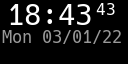

In [45]:
tablo.image

In [57]:
Widget.stop_all()
main()
tablo.update(12)

In [53]:
tablo.options.gpio_slowdown = 3
tablo.start_matrix(brightness=10)

In [21]:
tw = Test_W((256,64))
tw.start(rr=0.004)

In [21]:
import aiohttp  #instead requests
import json


class OWM_Weater_W(Widget):
    one_call_api = 'http://api.openweathermap.org/data/2.5/onecall'
    default_args = {
        "lang": "ru",
        "lat": "55.927305",
        "lon": "37.523576"
    }
    
    def __init__(self, size: tp.Tuple[int, int], position = (0,0)):
        super().__init__(size, position)
        with open("owm.key") as file:
            token = file.readline().rstrip()
        self.args = {"appid": token} | OWM_Weater_W.default_args
        self.data: tp.Dict[str, tp.Any] = self.update_data(True)
        self.font_obj = ImageFont.truetype(font_name, self.h)
        self.font_color = font_color

    def update_data(self, force=False) -> tp.Dict[str, tp.Any]:
        if force or self.data["dt"] > datetime.now() + 5*60:
            responce = requests.get(OWM_Weater_W.one_call_api+'?'+'&'.join(k+'='+v for k,v in self.args.itemsms()))
            self.data = json.load(responce.content)
        return self.data
        
    def update_frame(self) -> None:
        self.clear()
        weater = self.update_data()
        w_str = weather["current"]["temp"]
        self.draw.multiline_text((0,0), w_str, fill=self.font_color, font=self.font_obj)

In [138]:
asyncio.all_tasks()

{<Task pending name='Time_W' coro=<Widget._start() running at <ipython-input-2-68ec3501bdfe>:75> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf0bcbe80>()]>>,
 <Task pending name='Time_W' coro=<Widget._start() running at <ipython-input-2-68ec3501bdfe>:75> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf0bcbf40>()]>>,
 <Task pending name='Time_W' coro=<Widget._start() running at <ipython-input-2-68ec3501bdfe>:75> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf453e730>()]>>}

In [145]:
next(t for t in asyncio.all_tasks() if t.get_name() == 'Time_W')

<Task pending name='Time_W' coro=<Widget._start() running at <ipython-input-2-68ec3501bdfe>:75> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0xf0bcb6b8>()]>>